**Imports**

In [1]:
import json
from pprint import pprint
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pathlib import Path

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/tim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tim/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Constructing the basic dataset

In [3]:
data_folder = Path('../data/twint')
tweets_file = data_folder / 'data_new2.txt'

In [4]:
f = open(tweets_file, 'r')
lines = [l for l in f]
f.close()

In [5]:
tweets = [json.loads(l) for l in lines]
print(json.dumps(tweets[16200]))

{"id": 1126905717477257216, "conversation_id": "1126905717477257216", "created_at": 1557510234000, "date": "2019-05-10", "time": "19:43:54", "timezone": "+0200", "user_id": 1653081355, "username": "pauljdub", "name": "Paul Warren", "place": "", "tweet": "I'm a couple days late to this, but I 100% respect the #UberLyftStrike \n\nI stopped driving about 6 months ago, because I had an undisputable report placed on my driving profile for refusing to take a minor to a liquor store to buy alcohol for them.", "language": "en", "mentions": [], "urls": [], "photos": [], "replies_count": 0, "retweets_count": 0, "likes_count": 9, "hashtags": ["#uberlyftstrike"], "cashtags": [], "link": "https://twitter.com/pauljdub/status/1126905717477257216", "retweet": false, "quote_url": "", "video": 0, "near": "", "geo": "", "source": "", "user_rt_id": "", "user_rt": "", "retweet_id": "", "reply_to": [{"user_id": "1653081355", "username": "pauljdub"}], "retweet_date": "", "translate": "", "trans_src": "", "tr

In [6]:
print('Number of tweets:\t%s' % len(tweets))

Number of tweets:	51853


In [10]:
ts = [t for t in tweets if t['date'] == '2019-05-30']
len(ts)

802

# Top 20 Hashtags

In [9]:
hashtags = [h for t in tweets for h in t['hashtags']]

In [10]:
from collections import Counter
hashtags_count = pd.DataFrame.from_dict(Counter(hashtags), orient='index', columns=['count']).sort_values(by='count', ascending=False)[:20]
hashtags_count

,count
#uber,37820
#lyft,14880
#uberlyftstrike,3739
#uberipo,3357
#taxi,2501
#ipo,2452
#rideshare,1623
#uk,1557
#tfl,1510
#uberstrike,1429


In [11]:
all_hashtags = []
for t in tweets:
    hashtags = t['hashtags']
    for h in hashtags:
        all_hashtags.append(h)
                                  
hashtags_counter = Counter(all_hashtags)
hashtag_count_df = pd.DataFrame.from_dict(hashtags_counter, orient='index', columns=['count']).sort_values(by=['count'], ascending=False).head(10)
hashtag_count_df.plot(kind='bar', legend=False, figsize=(15, 5), fontsize=20)
plt.title('Hashtag Occurrences', fontsize=20)
plt.xticks(rotation=45)
plt.savefig('hashtag_occurrences.pdf', bbox_inches='tight')
plt.close()

## Tweet Time Distribution

In [12]:
dates_to_n_tweets = {}

for t in tweets:
    date = t['date'].split('-')[1] + '-' + t['date'].split('-')[2]
    try:
        dates_to_n_tweets[date] = dates_to_n_tweets[date] + 1
    except:
        dates_to_n_tweets[date] = 0

sorted_dates = sorted(dates_to_n_tweets.items())
plt.figure(1, figsize=(40, 20))
plt.bar([e[0] for e in sorted_dates], [e[1] for e in sorted_dates])
plt.title('Number of Tweets per Day', fontsize=20)
plt.xlabel('Day', fontsize=20)
plt.ylabel('Number of Tweets', fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.savefig('tweet_time_distribution.pdf', bbox_inches='tight')
plt.close()

# Text preparation

In [13]:
stop_words = stopwords.words('english')
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [14]:
def word_tokenize(tweet):
    return tokenizer.tokenize(tweet)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# https://stackoverflow.com/a/49146722/330558
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    #Remove numbers
    tweet = re.sub(r"[0-9]", '', tweet, flags=re.MULTILINE)
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove emojis
    tweet = remove_emoji(tweet)
    # Tokenize
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    # Stemming
    #shortened = [stemmer.stem(w) for w in filtered_words]
    # Lemmatizing
    lemmatized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words]
    # Remove non-alpha words
    lemmatized_filtered = [w for w in lemmatized if w.isalpha()]
    # Filter out short lemmas
    final_tokens = [w for w in lemmatized_filtered if len(w) > 2]
    
    return final_tokens

In [15]:
unique_usernames = {t['username'] for t in tweets}
users_to_documents = {u:[] for u in unique_usernames}

for tw in tweets:
    u = tw['username']
    t = preprocess_tweet_text(tw['tweet'])
    users_to_documents[u] = users_to_documents[u] + t

print(list(users_to_documents.items())[100])

('athomeactivism', ['people', 'wise', 'uber', 'lyft', 'dont', 'innovate', 'real', 'thing', 'there', 'innovation', 'cost', 'car', 'repair', 'fuel', 'etc', 'tech', 'innovation', 'new', 'way', 'find', 'driver', 'save', 'cheap', 'phone', 'call', 'real', 'innovation', 'cheap', 'labor', 'give', 'risk', 'contractor', 'pay', 'car', 'come', 'uber', 'lyft', 'scam', 'everyone', 'passenger', 'driver', 'uberlyftstrike', 'uberstrike', 'ubershutdown', 'uber', 'lyft', 'didnt', 'innovate', 'cost', 'car', 'cost', 'gas', 'repair', 'tire', 'uber', 'lyft', 'innovation', 'new', 'way', 'hail', 'taxi', 'rather', 'cent', 'phone', 'call', 'wave', 'hand', 'real', 'innovation', 'flood', 'market', 'drive', 'wage', 'uberlyftstrike', 'uber', 'scam', 'driver', 'business', 'people', 'control', 'price'])


In [16]:
print(len(users_to_documents.keys()))

25558


## Document Length and Lexical Diversity

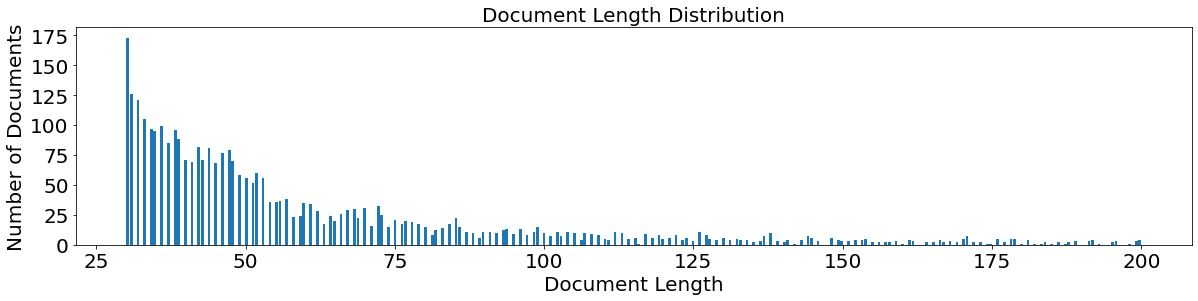

In [17]:
lengths = {u:len(doc) for (u, doc) in users_to_documents.items()}
min = np.min(list(lengths.values()))
max = np.max(list(lengths.values()))
bins = np.linspace(start=min, stop=max, num=300, endpoint=True)

labels = list(range(299))

lengths_df = pd.DataFrame({'Doc': list(lengths.keys()), 'Document Length': list(lengths.values())})

ax = lengths_df.hist(figsize=(20, 4), grid=False, bins=len(bins), range=(30, 200), rwidth=0.8)
ax[0][0].set_title('Document Length Distribution', fontsize=20)
ax[0][0].set_xlabel('Document Length', fontsize=20)
ax[0][0].set_ylabel('Number of Documents', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('document_length_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

### Filter out any users that now have less than 120 tokens

In [18]:
print(len(users_to_documents.values()))
users_to_documents_doc_length_filtered = {u:doc for (u, doc) in users_to_documents.items() if len(doc) >= 120}
print(len(users_to_documents_doc_length_filtered.values()))

25558
557


### Filter out any users with a very low lexical diversity

In [19]:
def lexical_diversity_percentage(tokens):
    return len(set(tokens)) / len(tokens) * 100

## Lexical diversity histogram

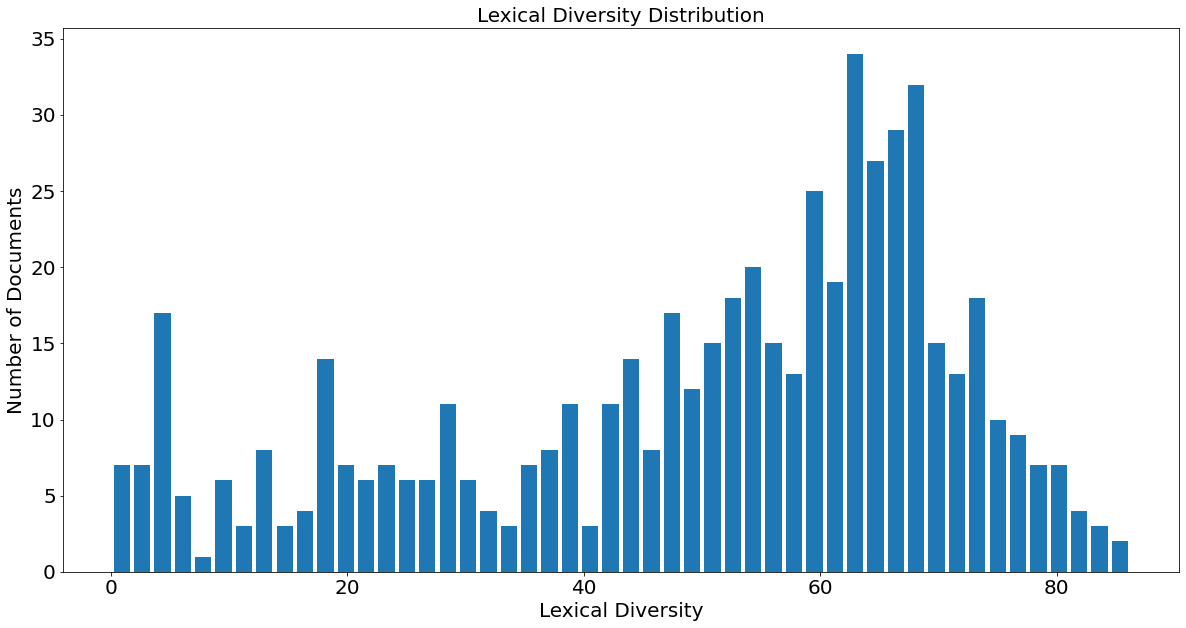

In [20]:
lexical_diversities = {u:lexical_diversity_percentage(doc) for (u, doc) in users_to_documents_doc_length_filtered.items()}
lexical_div_df = pd.DataFrame({'Doc': list(lexical_diversities.keys()), 'Lexical Diversity': list(lexical_diversities.values())})
ax = lexical_div_df.hist(grid=False, bins=50, figsize=(20, 10), rwidth=0.8)
ax[0][0].set_title('Lexical Diversity Distribution', fontsize=20)
ax[0][0].set_xlabel('Lexical Diversity', fontsize=20)
ax[0][0].set_ylabel('Number of Documents', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('lexical_diversity_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [21]:
print(len(users_to_documents_doc_length_filtered['uber4london']))
lexical_diversity_percentage(users_to_documents_doc_length_filtered['uber4london'])

17280


0.07523148148148148

In [22]:
print(len(users_to_documents_doc_length_filtered))
users_to_documents_filtered = {u:doc for (u, doc) in users_to_documents_doc_length_filtered.items() if lexical_diversity_percentage(doc) >= 48}
len(users_to_documents_filtered)
u

557


'worldsilicon'

# Constructing the Term/Document Matrix

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
docs = users_to_documents_filtered.values()

In [25]:
def do_nothing(tokens):
    return tokens

vectorizer = TfidfVectorizer(lowercase=False, tokenizer=do_nothing, min_df=0.2, max_df=0.8)

X = vectorizer.fit_transform(docs)

In [26]:
tf_idf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [27]:
tf_idf_df

,app,back,bad,big,billion,business,call,car,city,come,...,uberlyftstrike,ubers,use,want,way,week,well,work,would,year
0,0.132076,0.090090,0.000000,0.000000,0.037131,0.036983,0.066212,0.064449,0.022182,0.058516,...,0.000000,0.000000,0.300224,0.040030,0.06223,0.044363,0.074262,0.075166,0.039684,0.071407
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.063226,0.000000,0.067572,0.121590
2,0.148655,0.000000,0.173889,0.000000,0.000000,0.000000,0.000000,0.126943,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.157692,0.00000,0.000000,0.146273,0.148052,0.156327,0.000000
3,0.151010,0.000000,0.176644,0.000000,0.000000,0.000000,0.353289,0.257910,0.000000,0.000000,...,0.000000,0.170728,0.000000,0.160191,0.16602,0.000000,0.148591,0.000000,0.000000,0.000000
4,0.081634,0.000000,0.000000,0.086220,0.080326,0.040003,0.047746,0.000000,0.000000,0.084391,...,0.000000,0.092293,0.043298,0.000000,0.00000,0.000000,0.040163,0.000000,0.000000,0.038619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0.000000,0.705829,0.345838,0.000000,0.145457,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.156812,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
349,0.036713,0.000000,0.042946,0.077552,0.433502,0.000000,0.042946,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.036125,0.109693,0.000000,0.000000
350,0.080528,0.000000,0.000000,0.170105,0.079238,0.000000,0.000000,0.000000,0.000000,0.166497,...,0.679892,0.000000,0.000000,0.085424,0.00000,0.000000,0.000000,0.000000,0.000000,0.076191
351,0.000000,0.000000,0.000000,0.000000,0.449995,0.000000,0.000000,0.130177,0.358426,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.144231


In [28]:
tf_idf_df.iloc[:10, 60:70]

,stock,strike,take,taxi,think,time,today,try,uberipo,uberlyftstrike
0,0.089259,0.000000,0.077297,0.160120,0.124460,0.084083,0.000000,0.023121,0.597838,0.000000
1,0.121590,0.000000,0.000000,0.000000,0.070642,0.114540,0.064784,0.000000,0.135731,0.000000
2,0.000000,0.000000,0.121800,0.000000,0.000000,0.000000,0.000000,0.182165,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.320381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.038619,0.083334,0.033443,0.086597,0.000000,0.000000,0.000000,0.000000,0.043110,0.000000
5,0.091446,0.000000,0.079191,0.000000,0.000000,0.000000,0.097445,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.058835,0.076172,0.000000,0.000000,0.000000,0.175988,0.000000,0.000000
7,0.000000,0.000000,0.086844,0.000000,0.000000,0.000000,0.213725,0.259767,0.000000,0.255677
8,0.000000,0.000000,0.000000,0.104245,0.000000,0.087587,0.000000,0.120423,0.000000,0.000000
9,0.000000,0.060821,0.048817,0.000000,0.000000,0.265516,0.180211,0.073011,0.000000,0.287447


## Performing a PCA

In [29]:
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.normalize(tf_idf_df), columns=tf_idf_df.columns)
data_scaled

,app,back,bad,big,billion,business,call,car,city,come,...,uberlyftstrike,ubers,use,want,way,week,well,work,would,year
0,0.132076,0.090090,0.000000,0.000000,0.037131,0.036983,0.066212,0.064449,0.022182,0.058516,...,0.000000,0.000000,0.300224,0.040030,0.06223,0.044363,0.074262,0.075166,0.039684,0.071407
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.063226,0.000000,0.067572,0.121590
2,0.148655,0.000000,0.173889,0.000000,0.000000,0.000000,0.000000,0.126943,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.157692,0.00000,0.000000,0.146273,0.148052,0.156327,0.000000
3,0.151010,0.000000,0.176644,0.000000,0.000000,0.000000,0.353289,0.257910,0.000000,0.000000,...,0.000000,0.170728,0.000000,0.160191,0.16602,0.000000,0.148591,0.000000,0.000000,0.000000
4,0.081634,0.000000,0.000000,0.086220,0.080326,0.040003,0.047746,0.000000,0.000000,0.084391,...,0.000000,0.092293,0.043298,0.000000,0.00000,0.000000,0.040163,0.000000,0.000000,0.038619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0.000000,0.705829,0.345838,0.000000,0.145457,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.156812,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
349,0.036713,0.000000,0.042946,0.077552,0.433502,0.000000,0.042946,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.036125,0.109693,0.000000,0.000000
350,0.080528,0.000000,0.000000,0.170105,0.079238,0.000000,0.000000,0.000000,0.000000,0.166497,...,0.679892,0.000000,0.000000,0.085424,0.00000,0.000000,0.000000,0.000000,0.000000,0.076191
351,0.000000,0.000000,0.000000,0.000000,0.449995,0.000000,0.000000,0.130177,0.358426,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.144231


# Perform the PCA

In [30]:
pca = PCA(n_components=30)
X_reduced = pca.fit_transform(data_scaled)

In [31]:
len(X_reduced)

353

## Analyze the percentage of explained variance per principal component

In [32]:
pd.DataFrame(data={'PCA': [i+1 for i in range(0, len(pca.explained_variance_ratio_))],'Explained Variance': pca.explained_variance_ratio_})

,PCA,Explained Variance
0,1,0.125383
1,2,0.077134
2,3,0.054076
3,4,0.049704
4,5,0.038319
5,6,0.033597
6,7,0.028052
7,8,0.024165
8,9,0.023803
9,10,0.021019


In [33]:
explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(int(explained_variance * 100)))
print()

Explained variance of the PCA step: 74%



In [34]:
plt.figure(figsize=(20, 10))
ax = plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance in Relation to the Number of Principal Components', fontsize=20)
plt.xlabel('Explained Variance in Percentage', fontsize=20)
plt.ylabel('Number of Principal Components', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('explained_variance.pdf', bbox_inches='tight')
plt.close()

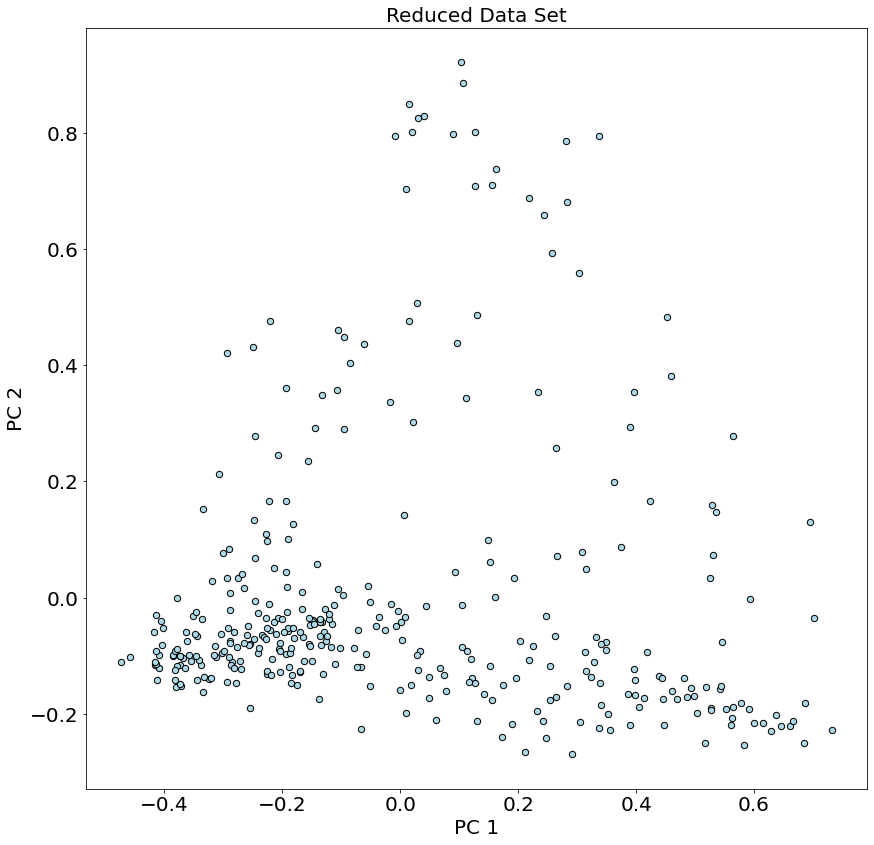

In [35]:
plt.figure(1, figsize=(14, 14))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='lightblue', edgecolor='black', s=40)
plt.title('Reduced Data Set', fontsize=20)
plt.xlabel('PC 1', fontsize=20)
plt.ylabel('PC 2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('pca_first_2_pcs.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [36]:
np.min(X_reduced[:, 1])

-0.2695781036783428

## 3D Plot

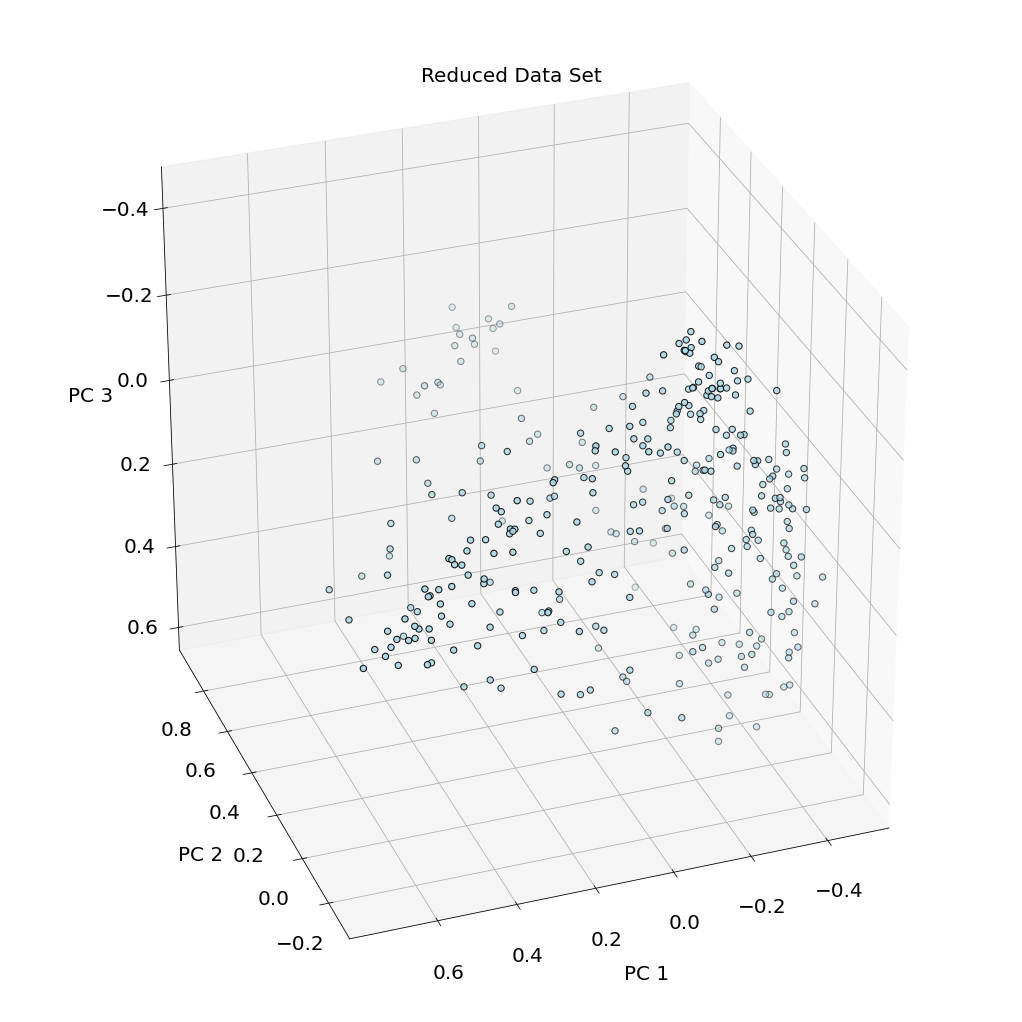

In [37]:
fig = plt.figure(1, figsize=(14, 14))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], color='lightblue', edgecolor='black', s=40)
ax.set_title('Reduced Data Set', fontsize=20)
ax.set_xlabel('PC 1', fontsize=20, labelpad=40)
ax.set_ylabel('PC 2', fontsize=20, labelpad=40)
ax.set_zlabel('PC 3', fontsize=20, labelpad=40)
ax.tick_params(labelsize=20, pad=20)
plt.savefig('pca_first_3_pcs.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [38]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important_feature_indexes_per_pc = {}

initial_feature_names = data_scaled.columns

dfs = []

for pc in range(n_pcs):
    components_enumerated = list(enumerate(pca.components_[pc]))
    components_sorted = sorted(components_enumerated, key=lambda x:np.abs(x[1]), reverse=True)
    features_imps = {initial_feature_names[i]:imp for (i, imp) in components_sorted}
    features_imps_df = pd.DataFrame.from_dict(features_imps, orient='index', columns = ['importance'] )[:10]
    dfs.append(features_imps_df)
    
dfs[2]

,importance
uberlyftstrike,0.552496
driver,0.519282
strike,0.297654
ipo,0.264821
taxi,-0.213645
know,-0.152077
pay,0.148680
car,-0.134816
ride,-0.129205
get,-0.126066


# Clustering

In [193]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [194]:
km = KMeans(n_clusters=3)
km.fit(X_reduced)

KMeans(n_clusters=3)

## Plotting the clusters

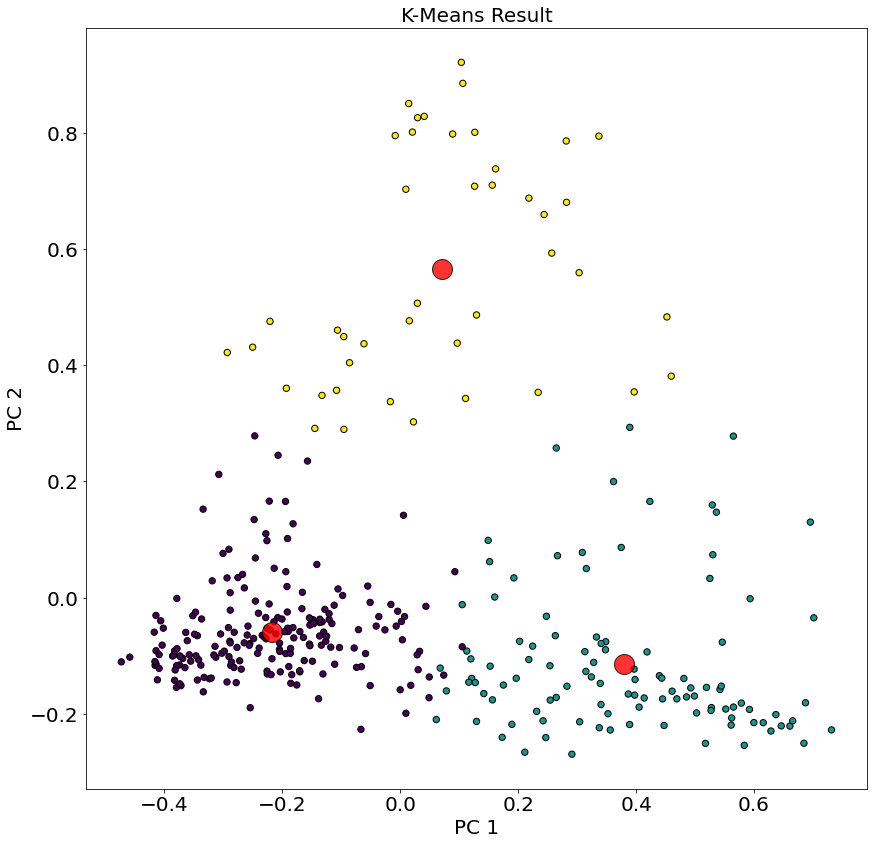

In [196]:
y_kmeans = km.labels_
plt.figure(figsize=(14, 14))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_kmeans, s=40, edgecolor='black')
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=400, alpha=0.8, edgecolor='black')
plt.tick_params(labelsize=20)
plt.xlabel('PC 1', fontsize=20)
plt.ylabel('PC 2', fontsize=20)
plt.title('K-Means Result', fontsize=20)
plt.savefig('k_means_result_2d.pdf', bbox_inches='tight')
plt.show()
plt.close()

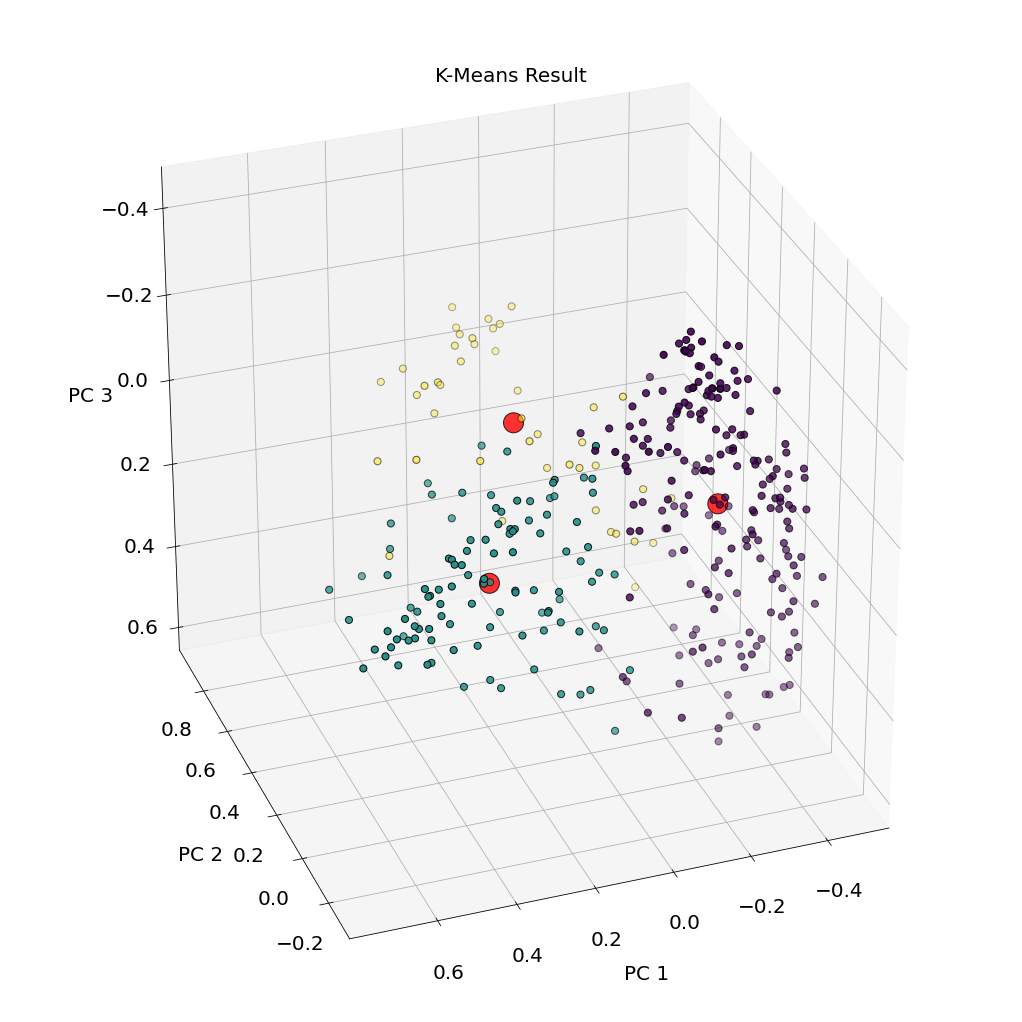

In [197]:
fig = plt.figure(1, figsize=(14, 14))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = Axes3D(fig, elev=-150, azim=110)
y = range(0, len(X_reduced))
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_kmeans, edgecolor='k', s=50)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=400, alpha=0.8, edgecolor='black')
ax.set_title('K-Means Result', fontsize=20)
ax.set_xlabel('PC 1', fontsize=20, labelpad=40)
ax.set_ylabel('PC 2', fontsize=20, labelpad=40)
ax.set_zlabel('PC 3', fontsize=20, labelpad=40)
ax.tick_params(labelsize=20, pad=20)
plt.savefig('k_means_result_3d.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Getting the users closest to the cluster centroids

In [159]:
distances

array([[0.67735286, 0.84410308, 0.42237642],
       [0.8856048 , 0.47417593, 0.90650219],
       [0.80491716, 0.98840163, 1.0558516 ],
       ...,
       [0.75434542, 0.95973484, 1.03088063],
       [0.80460071, 0.73064102, 1.01546196],
       [0.63946559, 0.77153161, 0.92105823]])

In [203]:
import numpy as np
def dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))

users_df = pd.DataFrame({'Username': list(users_to_documents_filtered.keys()), 'Cluster Label': km.labels_, 'Point X': X_reduced[:, 0], 'Point Y': X_reduced[:, 1], 'Point Z': X_reduced[:, 2]})

for i in range(0, len(users_df)):
    p = X_reduced[i]
    cluster = users_df.loc[i]['Cluster Label']
    cluster_coordinates = km.cluster_centers_[cluster]
    distance = dist(p[:2], cluster_coordinates[:2])
    users_df.loc[i, 'Distance'] = distance
    
users_cluster_0 = users_df[users_df['Cluster Label'] == 0]
users_cluster_1 = users_df[users_df['Cluster Label'] == 1]
users_cluster_2 = users_df[users_df['Cluster Label'] == 2]
    
cluster0_nearest_users = users_cluster_0.sort_values(by='Distance').head(10)
cluster1_nearest_users = users_cluster_1.sort_values(by='Distance').head(10)
cluster2_nearest_users = users_cluster_2.sort_values(by='Distance').head(10)

print(cluster0_nearest_users)
print()
print(cluster1_nearest_users)
print()
print(cluster2_nearest_users)
print()
print()
print(len(users_cluster_0))
print(len(users_cluster_1))
print(len(users_cluster_2))

print(users_cluster_0.mean())
print(users_cluster_1.mean())
print(users_cluster_2.mean())

            Username  Cluster Label   Point X   Point Y   Point Z  Distance
175       jaredaquan              0 -0.220747 -0.055607 -0.281629  0.004255
266    taryndipity36              0 -0.211260 -0.062198 -0.346201  0.007605
260      lennyisnuts              0 -0.226007 -0.052685 -0.016402  0.010066
339        ajkinohio              0 -0.227612 -0.070881 -0.384183  0.015206
299        zkesports              0 -0.230672 -0.067973 -0.286942  0.015418
232      tvaddict617              0 -0.234197 -0.064777 -0.178756  0.017063
345     goodcalluber              0 -0.214281 -0.041589 -0.024107  0.017815
289     kaisharkyboi              0 -0.196435 -0.058523 -0.268904  0.021720
77        limolittle              0 -0.204719 -0.078322 -0.273390  0.023550
234  suzanne_ssuz515              0 -0.207779 -0.034411 -0.274615  0.026666

            Username  Cluster Label   Point X   Point Y   Point Z  Distance
209      longmanbach              1  0.396698 -0.123062  0.026842  0.018700
28    realm

In [139]:
km.inertia_

155.9690964457906

## Plotting the clusters seperately

Text(0.5, 1.0, 'K-Means Result')

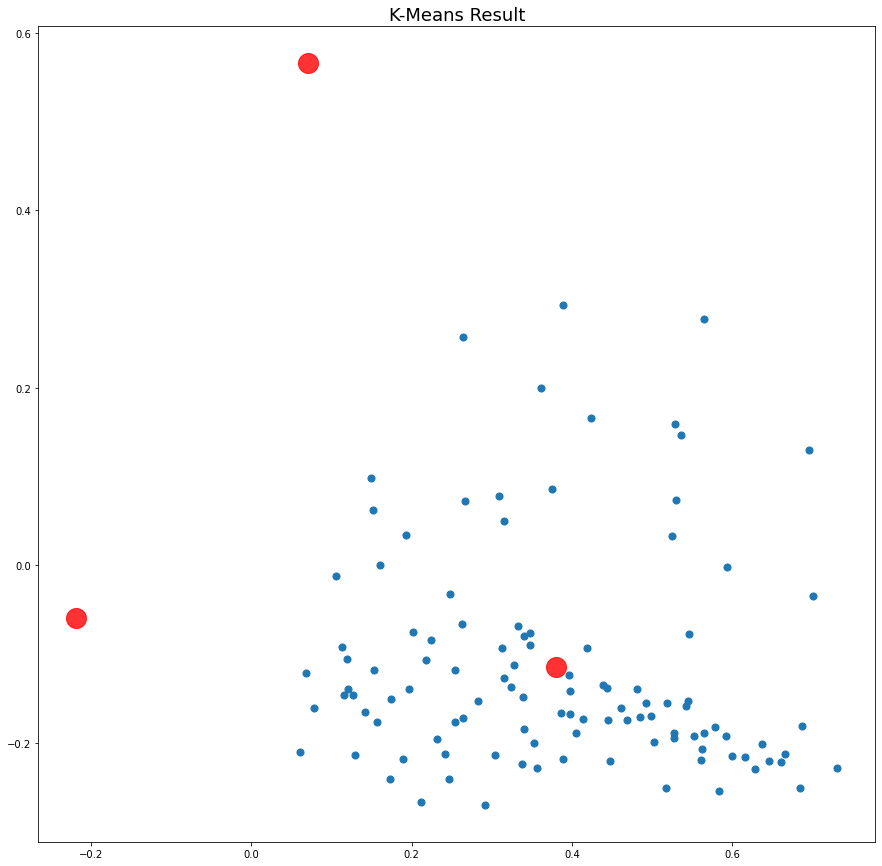

In [204]:
plt.figure(figsize=(15, 15))
plt.scatter(users_cluster_1['Point X'], users_cluster_1['Point Y'], s=50)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=400, alpha=0.8)
plt.title('K-Means Result', fontsize=18)

## Get the tweets per cluster

In [205]:
tweets_cluster0 = [t for t in tweets if t['username'] in list(users_cluster_0['Username'])]    
tweets_cluster1 = [t for t in tweets if t['username'] in list(users_cluster_1['Username'])]
tweets_cluster2 = [t for t in tweets if t['username'] in list(users_cluster_2['Username'])]
texts_cluster0 = [t['tweet'] for t in tweets_cluster0]
texts_cluster1 = [t['tweet'] for t in tweets_cluster1]
texts_cluster2 = [t['tweet'] for t in tweets_cluster2]
print(len(texts_cluster0))
print(len(texts_cluster1))
print(len(texts_cluster2))

2682
1860
1042


In [237]:
uberrape_tweets = [t for t in tweets if '#uberrape' in t['hashtags'] and '#london' in t['hashtags']]
uberrape_df = pd.DataFrame(uberrape_tweets)
[t['link'] for t in uberrape_tweets]

['https://twitter.com/NagleKieron/status/1133270967684403200',
 'https://twitter.com/StaySafeLondon/status/1128259357437722625',
 'https://twitter.com/NagleKieron/status/1127524805039808512',
 'https://twitter.com/lennythepen/status/1112975904337248256']

## Most used hashtags in the cluster

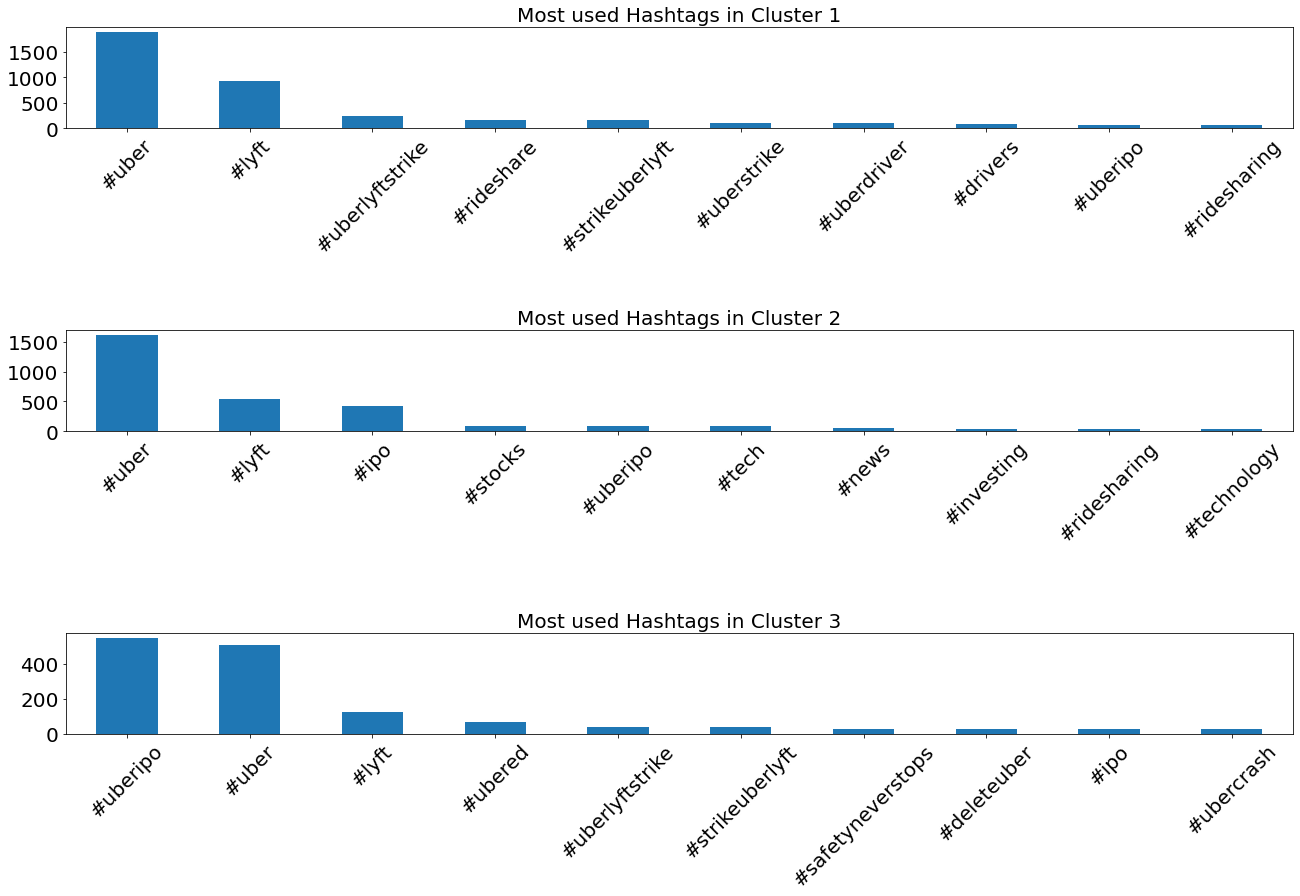

In [206]:
from collections import Counter

hashtags_cluster0 = [h for t in tweets_cluster0 for h in t['hashtags']]
hashtags_cluster1 = [h for t in tweets_cluster1 for h in t['hashtags']]
hashtags_cluster2 = [h for t in tweets_cluster2 for h in t['hashtags']]


c0 = Counter(hashtags_cluster0)
c1 = Counter(hashtags_cluster1)
c2 = Counter(hashtags_cluster2)

df0 = pd.DataFrame(index=[e[0] for e in c0.most_common(10)], data={'count': [e[1] for e in c0.most_common(10)]}).sort_values(by='count')[::-1]
df1 = pd.DataFrame(index=[e[0] for e in c1.most_common(10)], data={'count': [e[1] for e in c1.most_common(10)]}).sort_values(by='count')[::-1]
df2 = pd.DataFrame(index=[e[0] for e in c2.most_common(10)], data={'count': [e[1] for e in c2.most_common(10)]}).sort_values(by='count')[::-1]

fig, axes = plt.subplots(3, 1, figsize=(22, 13))

plt.subplots_adjust(hspace=2)

df0.plot(ax=axes[0], kind='bar', title='Most used Hashtags in Cluster 1', legend=False, fontsize=20)
df1.plot(ax=axes[1], kind='bar', title='Most used Hashtags in Cluster 2', legend=False, fontsize=20)
df2.plot(ax=axes[2], kind='bar', title='Most used Hashtags in Cluster 3', legend=False, fontsize=20)

for i in range(3):
    axes[i].title.set_size(20)
    axes[i].tick_params(axis='x', labelrotation=45)

plt.savefig('most_used_hashtags_per_cluster.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Number of Tweets per day per cluster

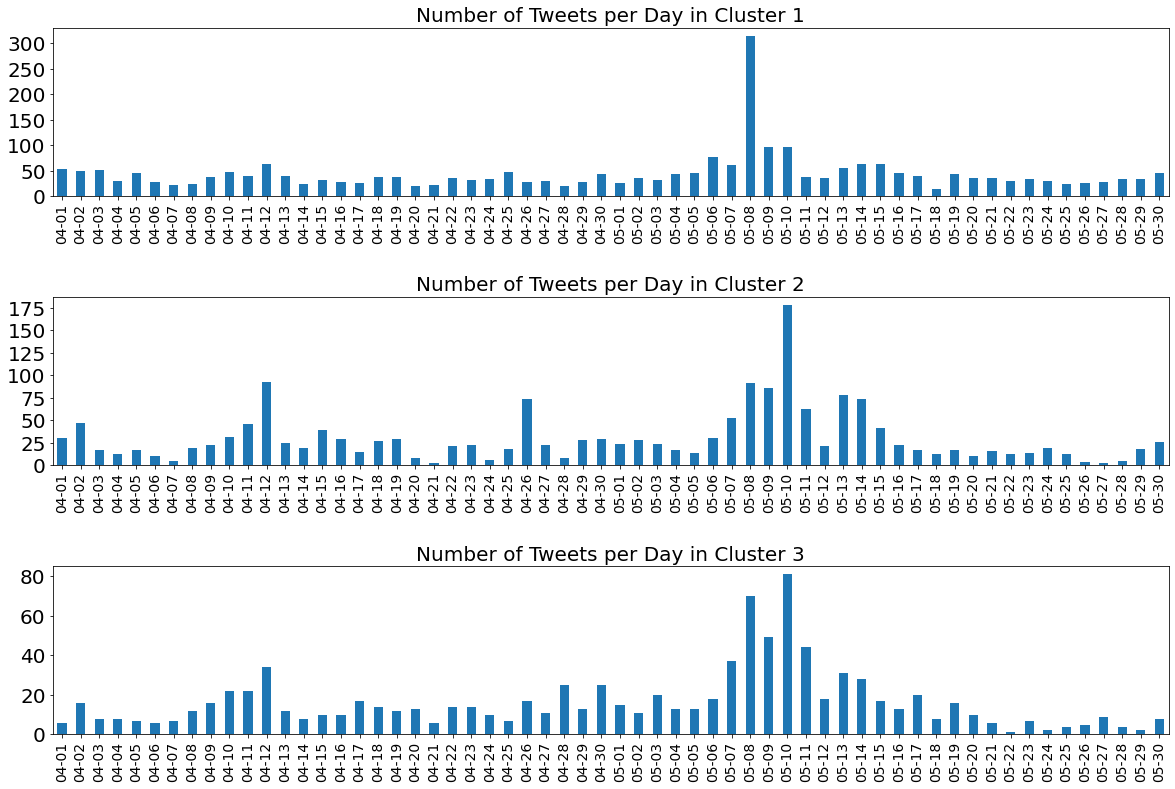

In [207]:
clusters = [tweets_cluster0, tweets_cluster1, tweets_cluster2]

import matplotlib.pyplot as plt
fig, axes = plt.subplots(3,1, figsize=(20, 13))
plt.subplots_adjust(hspace=0.6)
i = 0
for c in clusters:
    dates_to_n_tweets = {}
    for t in c:
        date = t['date'].split('-')[1] + '-' + t['date'].split('-')[2]
        try:
            dates_to_n_tweets[date] = dates_to_n_tweets[date] + 1
        except:
            dates_to_n_tweets[date] = 0

    sorted_dates = sorted(dates_to_n_tweets.items())
    df = pd.DataFrame({'date': [e[0] for e in sorted_dates], 'count': [e[1] for e in sorted_dates]})
    ax = df.plot(ax=axes[i], kind='bar', title='Number of Tweets per Day in Cluster %d' % (i+1), legend=False, fontsize=20)
    xlabels = df['date']
    ax.set_xticklabels(xlabels, fontsize=14)
    i+=1
    
axes[0].title.set_size(20)
axes[1].title.set_size(20)
axes[2].title.set_size(20)

plt.savefig('tweets_per_day_per_cluster.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Four Most liked and retweeted tweets per cluster

In [208]:
tweets_cluster0_sorted = sorted(tweets_cluster0, key=lambda t: t['likes_count'], reverse=True)
tweets_cluster1_sorted = sorted(tweets_cluster1, key=lambda t: t['likes_count'], reverse=True)
tweets_cluster2_sorted = sorted(tweets_cluster2, key=lambda t: t['likes_count'], reverse=True)

print(*[t for t in tweets_cluster0_sorted[:4]], sep='\n_________________________________________\n\n\n')
print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
print(*[t for t in tweets_cluster1_sorted[:4]], sep='\n_________________________________________\n\n\n')
print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
print(*[t for t in tweets_cluster2_sorted[:4]], sep='\n_________________________________________\n\n\n')

{'id': 1125588567508639744, 'conversation_id': '1125588567508639744', 'created_at': 1557196201000, 'date': '2019-05-07', 'time': '04:30:01', 'timezone': '+0200', 'user_id': 3586961474, 'username': 'dgorganize', 'name': 'Daniel Gross', 'place': '', 'tweet': 'I imagine some Uber and Lyft tech workers are grappling right now with whether to respect Wed’s strike.\n\nIt starts with a conversation with a single co-worker. “I’m thinking of walking out with the drivers, would you join me?”\n\n #StrikeUberLyft', 'language': 'en', 'mentions': [], 'urls': [], 'photos': [], 'replies_count': 10, 'retweets_count': 153, 'likes_count': 460, 'hashtags': ['#strikeuberlyft'], 'cashtags': [], 'link': 'https://twitter.com/dgorganize/status/1125588567508639744', 'retweet': False, 'quote_url': '', 'video': 0, 'near': '', 'geo': '', 'source': '', 'user_rt_id': '', 'user_rt': '', 'retweet_id': '', 'reply_to': [{'user_id': '3586961474', 'username': 'dgorganize'}], 'retweet_date': '', 'translate': '', 'trans_src

# Shifterator Analysis

In [73]:
!pip3 install shifterator

In [74]:
import shifterator as sh

In [75]:
tokens_cluster0 = [t for (u, doc) in users_to_documents_doc_length_filtered.items() if u in list(users_cluster_0['Username']) for t in doc]    
tokens_cluster1 = [t for (u, doc) in users_to_documents_doc_length_filtered.items() if u in list(users_cluster_1['Username']) for t in doc]    
tokens_cluster2 = [t for (u, doc) in users_to_documents_doc_length_filtered.items() if u in list(users_cluster_2['Username']) for t in doc]    

In [76]:
token_freqs_cluster_0 = dict(Counter(tokens_cluster0))
token_freqs_cluster_1 = dict(Counter(tokens_cluster1))
token_freqs_cluster_2 = dict(Counter(tokens_cluster2))

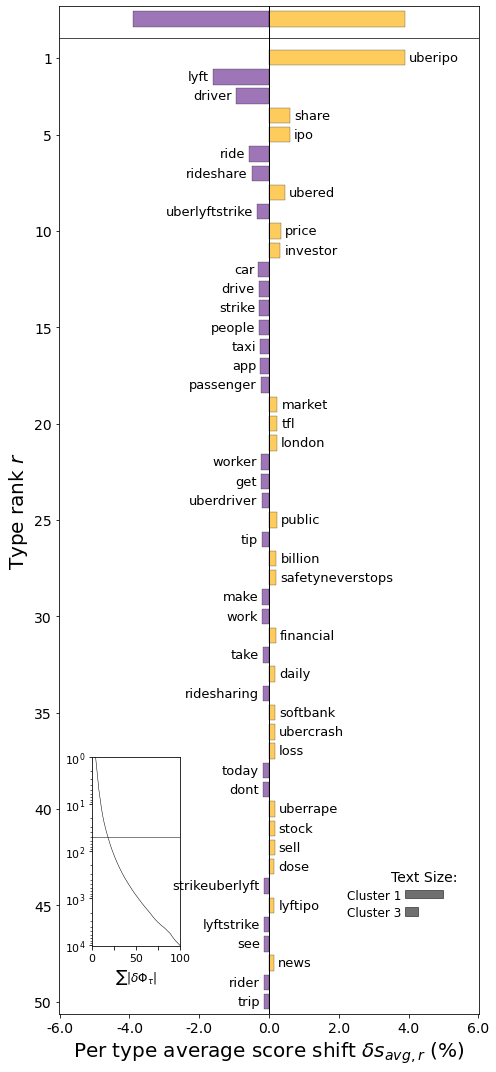

In [216]:
shift = sh.ProportionShift(type2freq_1=token_freqs_cluster_0, type2freq_2=token_freqs_cluster_2)
shift.get_shift_graph(system_names = ['Cluster 1', 'Cluster 3'], filename='entropy_shift_cluster1_cluster3.pdf')